In [15]:
from docplex.mp.model import Model
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import distance_matrix as dm
import pandas as pd
import os

TARGET_WEEKDAY = 0  # 0 = Monday, 1 = Tuesday, ..., 6 = Sunday
TARGET_HOUR = 8  # 0 = 00:00, 1 = 01:00, ..., 23 = 23:00

load_dotenv()

api_key = os.getenv("GOOGLE_MAPS_API_KEY")

matrix_time_first_tw, matrix_distance = dm.main(TARGET_WEEKDAY, TARGET_HOUR, api_key)
matrix_time_second_tw, matrix_distance = dm.main(
    TARGET_WEEKDAY, TARGET_HOUR + 1, api_key
)
matrix_time_third_tw, matrix_distance = dm.main(
    TARGET_WEEKDAY, TARGET_HOUR + 2, api_key
)
matrix_time_fourth_tw, matrix_distance = dm.main(
    TARGET_WEEKDAY, TARGET_HOUR + 3, api_key
)

print(matrix_time_first_tw)
print("\n\n")
print(matrix_time_second_tw)
print("\n\n")
print(matrix_time_third_tw)
print("\n\n")
print(matrix_time_fourth_tw)
print("\n\n")
print(matrix_distance)

# sava datas in a matrix of matrixes
first_data = matrix_time_first_tw
second_data = matrix_time_second_tw
third_data = matrix_time_third_tw
fourth_data = matrix_time_fourth_tw

data = [first_data, second_data, third_data, fourth_data]

# parameters for time model
c = 20  # number of nodes
d = [8, 9, 10, 11, 12]  # time intervals
tw = [
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
]  # time windows
q = [
    0,
    10,
    10,
    -10,
    10,
    10,
    -10,
    10,
    10,
    -10,
    10,
    10,
    10,
    -10,
    10,
    10,
    10,
    10,
    -10,
    10,
]  # quantity of goods to collect/deliver
Q = 500  # maximum capacity of the vehicle
t_mv = 0.5  # time to move one item in/out from a vehicle [min]
M = 100000  # big M
tot_q = 0  # total quantity of goods to collect/delivery
del_q = 0  # quantity of goods to deliver
v = 20
for good in q:
    tot_q += abs(good)

tot_t_mv = tot_q * t_mv

print("Total time required to collect/deliver all goods:", tot_t_mv, "minutes")

for good in q:
    if good < 0:
        del_q += good
del_q = abs(del_q)

print(f"Computing for {v} vehicles")

# define model
mdl = Model("CVRP")
mdl.parameters.timelimit = 60

# decision variables

x = mdl.binary_var_dict(
    (
        (i, j, t, k)
        for i in range(c)
        for j in range(c)
        for t in range(len(d) - 1)
        for k in range(v)
    ),
    name="x",
)  # x == 1 if it is true that we are going from node i to node j at time t with vehicle k
T = mdl.continuous_var_matrix(
    c + 1, v, name="t"
)  # arrival time at node i for vehicle k
C = mdl.continuous_var_matrix(
    c, v, name="C"
)  # quantity of goods when you leave node i for vehicle k

# nodes constraints
for k in range(v):
    mdl.add_constraint(
        mdl.sum(mdl.sum(x[0, j, t, k] for j in range(1, c)) for t in range(len(d) - 1))
        <= 1  # TO CHANGE FROM ==(it was a test to make boot vehicle works) to <=
    )  # every vehicle must leave the depot exactly once, hence every vehicle is expoloited

for k in range(v):
    mdl.add_constraint(
        mdl.sum(mdl.sum(x[j, 0, t, k] for j in range(1, c)) for t in range(len(d) - 1))
        == mdl.sum(
            mdl.sum(x[0, j, t, k] for j in range(1, c)) for t in range(len(d) - 1)
        )
    )  # every vehicle that has left the depot must return to it

for j in range(1, c):
    mdl.add_constraint(
        mdl.sum(
            mdl.sum(
                mdl.sum(x[i, j, t, k] for i in range(c) if i != j)
                for t in range(len(d) - 1)
            )
            for k in range(v)
        )
        == 1
    )  # every node must be visited exactly once

for k in range(v):
    for j in range(1, c):
        mdl.add_constraint(
            mdl.sum(
                mdl.sum(x[i, j, t, k] for i in range(c) if i != j)
                for t in range(len(d) - 1)
            )
            == mdl.sum(
                mdl.sum(x[j, i, t, k] for i in range(c) if i != j)
                for t in range(len(d) - 1)
            )
        )  # when you visit a node you ought to leave it

# time
for k in range(v):
    for t in range(len(d) - 1):
        mdl.add_constraint(
            T[0, k] >= d[t] * 60 * mdl.sum(x[0, j, t, k] for j in range(1, c))
        )  # when you leave depot at a time t, you ought to leave it at that time

for k in range(v):
    for t in range(len(d) - 1):
        for j in range(1, c):
            mdl.add_constraint(
                T[j, k] >= d[t] * 60 * mdl.sum(x[i, j, t, k] for i in range(1, c))
            )  # when you arrive at a node j from node i at time t, you ought to arrive at that time

for k in range(v):
    for t in range(len(d) - 1):
        for j in range(1, c):
            mdl.add_constraint(
                T[j, k]
                <= d[t + 1] * 60 + (1 - mdl.sum(x[i, j, t, k] for i in range(1, c))) * M
            )  # when arrive in j from i at time t, you ought to reach it before the end of the time interval

for k in range(v):
    for t in range(len(d) - 1):
        for i in range(1, c):
            mdl.add_constraint(
                T[i, k] >= d[t] * 60 * mdl.sum(x[i, j, t, k] for j in range(0, c))
            )  # when you arrive at node j from node i at time t, you ought to depart in that time interval

for k in range(v):
    for t in range(len(d) - 1):
        for i in range(1, c):
            mdl.add_constraint(
                T[i, k]
                <= d[t + 1] * 60 + (1 - mdl.sum(x[i, j, t, k] for j in range(0, c))) * M
            )  # when you arrive in j from i at time t, you ought to depart from i after the start of that time interval

for k in range(v):
    for i in range(c):
        for j in range(1, c):
            for t in range(len(d) - 1):
                if i != j:
                    mdl.add_constraint(
                        (1 - x[i, j, t, k]) * M + T[j, k] - T[i, k]
                        >= data[t][i][j] + t_mv * abs(q[j])
                    )
                    mdl.add_constraint(
                        (1 - x[i, j, t, k]) * M - T[j, k] + T[i, k]
                        >= -data[t][i][j] - t_mv * abs(q[j])
                    )  # if you go from i to j, then the difference between the arrival time at j and i should be the same as the time required to go from i to j
                    # plus the time to load/unload the required goods

for k in range(v):
    for t in range(len(d) - 1):
        for i in range(1, c):
            mdl.add_constraint(
                (1 - x[i, 0, t, k]) * M + T[c, k] - T[i, k] >= data[t][i][0]
            )
            mdl.add_constraint(
                (1 - x[i, 0, t, k]) * M - T[c, k] + T[i, k] >= -data[t][i][0]
            )  # if you go from i to the depot, then the difference between the arrival time at the depot and i should be the same as the time required to go
            # from i to the depot

for k in range(v):
    for i in range(1, c):
        mdl.add_constraint(
            tw[i - 1][0] * 60 <= T[i, k]
        )  # you must arrive in i on-time (based on client side) lowest limit
        mdl.add_constraint(
            T[i, k] <= tw[i - 1][1] * 60
        )  # you must arrive in i on-time (based on client side) upper limit

for k in range(v):
    mdl.add_constraint(
        T[c, k] - T[0, k] <= 8 * 60
    )  # you must return to the depot within 8 hours (a shift)

# quantity constraints
for k in range(v):
    for t in range(len(d) - 1):
        for i in range(c):
            for j in range(1, c):
                if i != j:
                    mdl.add_constraint(
                        C[i, k] - C[j, k] + q[j] <= (1 - x[i, j, t, k]) * M
                    )
                    mdl.add_constraint(
                        C[j, k] - C[i, k] - q[j] <= (1 - x[i, j, t, k]) * M
                    )  # if you go from i to j, then the difference between the quantity of goods at i and j should be the same as the quantity
                    # of goods to deliver at j

for k in range(v):
    for i in range(c):
        mdl.add_constraint(
            max(0, q[i]) <= C[i, k]
        )  # if node i requires to load goods, you must leave i with at least the quantity of goods to collect
        mdl.add_constraint(
            C[i, k] <= min(Q, Q + q[i])
        )  # you must leave i with at most Q+q[i] goods if you have to deliver at node i goods or Q if you have to collect goods at node i

for k in range(v):
    del_qi = 0
    for j in range(1, c):
        if q[j] < 0:
            del_qi += q[j] * mdl.sum(
                mdl.sum(x[i, j, t, k] for i in range(c)) for t in range(len(d) - 1)
            )
    mdl.add_constraint(
        C[0, k] >= -del_qi
    )  # each vehicle must depart from the depot with at least the quantity of goods to deliver for its route

# objective function
mdl.minimize(
    mdl.sum(
        mdl.sum(
            mdl.sum(
                mdl.sum(x[i, j, t, k] * data[t][i][j] for i in range(c))
                for j in range(c)
            )
            for t in range(len(d) - 1)
        )
        for k in range(v)
    )
)  # minimize time of routes

sol = mdl.solve()

if sol is None:
    print("No solution found")

print("\n\n\nTotal time required is:")

print(sol.objective_value)

print(sol.objective_value + tot_t_mv)

print("\n\n\n")


counter_vehicles=0
for k in range(v):
    counter_routes=0
    for t in range(len(d)-1):
        for i in range(c):
            for j in range(c):
                 counter_routes+= sol.get_value(x[i, j, t, k])
    if counter_routes==0 :
        print(f"vehicle {k} is NOT used")
    else:
        print(f"vehicle {k} is used")
        counter_vehicles+=1

print(f"Total number of used vehicles: {counter_vehicles}")

Loading time matrix from file...
Loading time matrix from file...
Loading time matrix from file...
Loading time matrix from file...
[[ 0.   19.83 17.05 19.62 23.92 22.42 12.47 20.5  12.47 21.32 21.98 22.3
  22.6   5.62 28.78  9.45 13.38 31.75 10.65 12.58]
 [ 9.43  0.   11.13 13.62 18.42 16.82 15.68 26.9  11.3  23.18 17.   18.1
  17.12  9.87 24.17 15.05 13.78 29.88 14.68 12.8 ]
 [24.72 19.32  0.    8.93  7.77  5.98 28.52 40.87 22.82 11.35  5.35 10.15
   6.35 21.8  12.95 28.87 24.05 18.22 20.22 23.03]
 [20.77 12.87  5.97  0.    4.92  5.15 21.28 37.35 16.93 14.62 11.83 12.98
   3.55 19.3  12.45 25.72 19.68 17.75 13.82 18.73]
 [19.42 29.63 26.97 28.25  0.   25.88 28.88 34.63 25.35 17.1  27.15 28.68
  26.53 16.08 23.85 22.77 28.05 26.92 17.78 27.18]
 [21.   13.13  6.2   3.32  5.23  0.   21.33 37.98 17.25 14.85 11.97 13.15
   3.85 20.37 12.8  25.95 19.92 17.97 14.2  18.78]
 [13.43 23.9  19.48 23.08 27.   25.    0.   27.4   8.48 31.28 24.73 21.5
  25.35 17.33 31.13 16.93  9.3  38.92 22.55  8.

In [33]:
from docplex.mp.model import Model
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import distance_matrix as dm
import pandas as pd
import os

TARGET_WEEKDAY = 0  # 0 = Monday, 1 = Tuesday, ..., 6 = Sunday
TARGET_HOUR = 8  # 0 = 00:00, 1 = 01:00, ..., 23 = 23:00

load_dotenv()

api_key = os.getenv("GOOGLE_MAPS_API_KEY")

matrix_times, matrix_distance = dm.main(TARGET_WEEKDAY, TARGET_HOUR, api_key)

# parameters for time model
c = 7  # number of nodes
q = [
    0,
    10,
    10,
    -10,
    10,
    10,
    -10,
]   # quantity of goods to collect/deliver
Q = 100  # maximum capacity of the vehicle
distances = matrix_distance  # should match value of c
A = [(i, j) for i in range(c) for j in range(c) if i != j]
N0 = list(range(1, c))  # Nodi clienti (escluso il deposito)
L = 100  # Capacità massima della batteria
a = {(i, j): 2 for (i, j) in A}  # Consumo base per arco
b = {(i, j): 0.5 for (i, j) in A}  # Consumo dipendente dal carico
c_E = 1  # Costo per unità di energia consumata
c_F = 1  # Costo fisso per veicolo
c_M = 1  # Costo per unità di distanza

v = 3  # Number of vehicles

for i in range(len(distances)):
    for j in range(len(distances)):
        distances[i][j] = distances[i][j] / 1000  # Convert meters to kilometers

mdl_energy = Model("EnergyOptimization")

# Variabili di decisione

x_energy = mdl_energy.binary_var_cube(
    len(distances), len(distances), v, name="x"
)  # Percorsi
f = mdl_energy.continuous_var_cube(
    len(distances), len(distances), v, name="f"
)  # Flussi di carico
w = mdl_energy.continuous_var_list(v, name="w")  # Consumo massimo di energia

# Funzione obiettivo: Minimizzare i costi energetici

mdl_energy.minimize(
    mdl_energy.sum(
        [
            mdl_energy.sum([c_F * x_energy[0, j, k] for j in range(1, len(distances))])
            + mdl_energy.sum([c_M * distances[i][j]*x_energy[i, j, k]  for i, j in A])
            + c_E * w[k]
            for k in range(v)
        ]
    )
)

# Vincoli
for k in range(v):
    mdl_energy.add_constraint(mdl_energy.sum(x_energy[0, j, k] for j in N0) <= 1)

for i in N0:
    mdl_energy.add_constraint(
        mdl_energy.sum(
            x_energy[i, j, k] for k in range(v) for j in range(len(distances)) if j != i
        )
        == 1
    )

for i in range(len(distances)):
    mdl_energy.add_constraint(
        mdl_energy.sum(x_energy[j, i, k] for j in range(len(distances)) if j != i)
        == mdl_energy.sum(x_energy[i, j, k] for j in range(len(distances)) if j != i)
    )

for i, j in A:
    for k in range(v):
        mdl_energy.add_constraint(q[j] * x_energy[i, j, k] <= f[i, j, k])
        mdl_energy.add_constraint(f[i, j, k] <= (Q - q[i]) * x_energy[i, j, k])

for i in N0:
    mdl_energy.add_constraint(
        mdl_energy.sum(
            f[j, i, k] for k in range(v) for j in range(len(distances)) if j != i
        )
        - mdl_energy.sum(
            f[i, j, k] for k in range(v) for j in range(len(distances)) if j != i
        )
        == q[i]
    )

for k in range(v):
    mdl_energy.add_constraint(
        mdl_energy.sum(a[i, j] * x_energy[i, j, k] + b[i, j] * f[i, j, k] for i, j in A)
        <= w[k]
    )

for k in range(v):
    mdl_energy.add_constraint(0 <= w[k])
    mdl_energy.add_constraint(w[k] <= L)

# Risoluzione del modello

solution = mdl_energy.solve(log_output=False)

cost = solution.objective_value

if solution is None:
    print("Il modello non ha soluzione")
else:
    print("Costo totale:", solution.objective_value)
    for k in range(v):
        print(
            f"Consumo massimo del veicolo {k}: {solution.get_value(mdl_energy.get_var_by_name(f'w_{k}'))}"
        )

w = solution.get_values(w)

for w in w:
    if w == 0:
        unused_vehicle = True
        print("\nEsistono uno o più veicoli che non vengono utilizzati")
        break

for k in range(v):
    for i in range(c):
        for j in range(c):
            if solution.get_value(f[i, j, k]) != 0:
                print(
                    f"f[{i},{j},{k}]:{solution.get_value(f[i,j,k])}"
                    )

Loading time matrix from file...


Costo totale: 57.345
Consumo massimo del veicolo 0: 20.0
Consumo massimo del veicolo 1: 19.0
Consumo massimo del veicolo 2: 0

Esistono uno o più veicoli che non vengono utilizzati
f[2,5,0]:10.0
f[3,4,0]:10.0
f[0,2,1]:20.0
f[6,1,1]:10.0


Loading time matrix from file...
Loading time matrix from file...
Loading time matrix from file...
Loading time matrix from file...
[[    0.  3448.  3279.  3779.  4910.  4623.  2733.  4373.  2921.  5003.
   4158.  4970.  4629.  1184.  6568.  2130.  3088.  7292.  2499.  3012.]
 [ 2219.     0.  2048.  2548.  3679.  3392.  3253.  5470.  2689.  4170.
   2927.  3645.  3399.  2279.  4438.  3500.  2942.  6354.  2397.  2866.]
 [ 5046.  3542.     0.  2153.  1631.  1344.  5768. 11684.  4358.  2122.
    879.  2125.  1351.  4339.  2390.  5857.  4525.  4306.  3722.  4449.]
 [ 4525.  2516.  1319.     0.   910.   968.  5023. 11374.  4464.  2321.
   2250.  2956.   630.  4571.  2371.  6089.  4406.  4287.  2695.  4517.]
 [ 4157.  5769.  6708.  6211.     0.  5422.  6427.  7691.  5958.  3604.
   5470.  6430.  5429.  3469.  5189.  4967.  6231.  5914.  3733.  6155.]
 [ 4468.  2458.  1262.   809.  1073.     0.  4966.  7718.  4181.  2483.
   2141.  2899.   793.  4733.  2533.  5748.  4348.  4449.  2638.  4272.

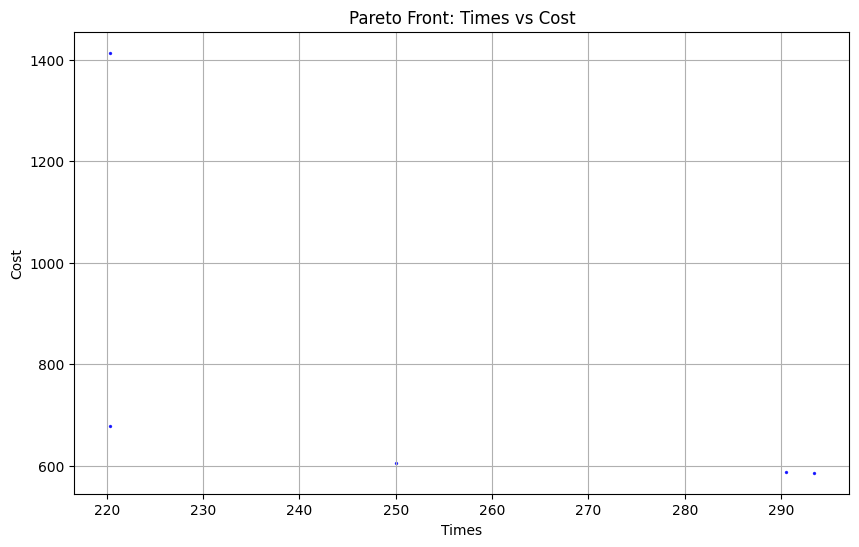

times [220.29999999999998, 220.29999999999998, 249.99999999999997, 290.51000000000005, 293.44000000008805]
[[], [220.29999999999998, 0.0], [220.29999999999998, 0.25], [249.99999999999997, 0.5], [290.51000000000005, 0.75], [293.44000000008805, 1.0]]
5
costs [1413.7939999999999, 678.7939999999999, 606.2009999989995, 588.3229999954982, 586.4589999975]
5
[[], [1413.7939999999999, 0.0], [678.7939999999999, 0.25], [606.2009999989995, 0.5], [588.3229999954982, 0.75], [586.4589999975, 1.0]]


In [1]:
from docplex.mp.model import Model
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import distance_matrix as dm
import numpy as np
import pandas as pd
import os

TARGET_WEEKDAY = 0  # 0 = Monday, 1 = Tuesday, ..., 6 = Sunday
TARGET_HOUR = 8  # 0 = 00:00, 1 = 01:00, ..., 23 = 23:00

load_dotenv()

api_key = os.getenv("GOOGLE_MAPS_API_KEY")

matrix_time_first_tw, matrix_distance = dm.main(TARGET_WEEKDAY, TARGET_HOUR, api_key)
matrix_time_second_tw, matrix_distance = dm.main(
    TARGET_WEEKDAY, TARGET_HOUR + 1, api_key
)
matrix_time_third_tw, matrix_distance = dm.main(
    TARGET_WEEKDAY, TARGET_HOUR + 2, api_key
)
matrix_time_fourth_tw, matrix_distance = dm.main(
    TARGET_WEEKDAY, TARGET_HOUR + 3, api_key
)


# sava datas in a matrix of matrixes
first_data = matrix_time_first_tw
second_data = matrix_time_second_tw
third_data = matrix_time_third_tw
fourth_data = matrix_time_fourth_tw
data = [first_data, second_data, third_data, fourth_data]

# parameters for time model
c = 20  # number of nodes
d = [8, 9, 10, 11, 12]  # time intervals
tw = [
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
    [8, 12],
]  # time windows
q = [
    0,
    10,
    10,
    -10,
    10,
    10,
    -10,
    10,
    10,
    -10,
    10,
    10,
    10,
    -10,
    10,
    10,
    10,
    10,
    -10,
    10,
]  # quantity of goods to collect/deliver
Q = 500  # maximum capacity of the vehicle
t_mv = 0.5  # time to move one item in/out from a vehicle [min]
M = 100000  # big M
tot_q = 0  # total quantity of goods to collect/delivery
del_q = 0  # quantity of goods to deliver
v = 5
# parameters for energy model
distances = matrix_distance  # should match value of c
print(distances)
A = [(i, j) for i in range(c) for j in range(c) if i != j]
N0 = list(range(1, c))  # Nodi clienti (escluso il deposito)
L = 1000  # Capacità massima della batteria
a = {(i, j): 2 for (i, j) in A}  # Consumo base per arco
b = {(i, j): 0.5 for (i, j) in A}  # Consumo dipendente dal carico
b= 0.5
c_E = 1 # Costo per unità di energia consumata
c_F = 1  # Costo fisso per veicolo
c_M = 1  # Costo per unità di distanza

unused_vehicle = False

for good in q:
    tot_q += abs(good)

tot_t_mv = tot_q * t_mv

print("Total time required to collect/deliver all goods:", tot_t_mv, "minutes")

for good in q:
    if good < 0:
        del_q += good
del_q = abs(del_q)

print(f"Computing for {v} vehicles")

# define model
mdl = Model("Pareto")

# decision variables of time model

x = mdl.binary_var_dict(
    (
        (i, j, t, k)
        for i in range(c)
        for j in range(c)
        for t in range(len(d) - 1)
        for k in range(v)
    ),
    name="x",
)  # x == 1 if it is true that we are going from node i to node j at time t with vehicle k
T = mdl.continuous_var_matrix(
    c + 1, v, name="t"
)  # arrival time at node i for vehicle k
C = mdl.continuous_var_matrix(
    c, v, name="C"
)  # quantity of goods when you leave node i for vehicle k

# decison variables of energy model

x_energy = [[[ 0 for _ in range(v)] for _ in range(c)] for _ in range(c)]

for k in range(v):
    for i in range(c):
        for j in range(c):
            for t in range(len(d)-1):
                x_energy[i][j][k] += x[i, j, t, k] 


w = mdl.continuous_var_list(v, name="w")  # max consuption of energy

#contraints of time model
# nodes constraints
for k in range(v):
    mdl.add_constraint(
        mdl.sum(mdl.sum(x[0, j, t, k] for j in range(1, c)) for t in range(len(d) - 1))
        == 1  
    )  # every vehicle must leave the depot exactly once, hence every vehicle is expoloited

for k in range(v):
    mdl.add_constraint(
        mdl.sum(mdl.sum(x[j, 0, t, k] for j in range(1, c)) for t in range(len(d) - 1))
        == 1
    )  # every vehicle that has left the depot must return to it

for j in range(1, c):
    mdl.add_constraint(
        mdl.sum(
            mdl.sum(
                mdl.sum(x[i, j, t, k] for i in range(c) if i != j)
                for t in range(len(d) - 1)
            )
            for k in range(v)
        )
        == 1
    )  # every node must be visited exactly once

for k in range(v):
    for j in range(1, c):
        mdl.add_constraint(
            mdl.sum(
                mdl.sum(x[i, j, t, k] for i in range(c) if i != j)
                for t in range(len(d) - 1)
            )
            == mdl.sum(
                mdl.sum(x[j, i, t, k] for i in range(c) if i != j)
                for t in range(len(d) - 1)
            )
        )  # when you visit a node you ought to leave it

# time
for k in range(v):
    for t in range(len(d) - 1):
        mdl.add_constraint(
            T[0, k] >= d[t] * 60 * mdl.sum(x[0, j, t, k] for j in range(1, c))
        )  # when you leave depot at a time t, you ought to leave it at that time

for k in range(v):
    for t in range(len(d) - 1):
        for j in range(1, c):
            mdl.add_constraint(
                T[j, k] >= d[t] * 60 * mdl.sum(x[i, j, t, k] for i in range(1, c))
            )  # when you arrive at a node j from node i at time t, you ought to arrive at that time

for k in range(v):
    for t in range(len(d) - 1):
        for j in range(1, c):
            mdl.add_constraint(
                T[j, k]
                <= d[t + 1] * 60 + (1 - mdl.sum(x[i, j, t, k] for i in range(1, c))) * M
            )  # when arrive in j from i at time t, you ought to reach it before the end of the time interval

for k in range(v):
    for t in range(len(d) - 1):
        for i in range(1, c):
            mdl.add_constraint(
                T[i, k] >= d[t] * 60 * mdl.sum(x[i, j, t, k] for j in range(0, c))
            )  # when you arrive at node j from node i at time t, you ought to depart in that time interval

for k in range(v):
    for t in range(len(d) - 1):
        for i in range(1, c):
            mdl.add_constraint(
                T[i, k]
                <= d[t + 1] * 60 + (1 - mdl.sum(x[i, j, t, k] for j in range(0, c))) * M
            )  # when you arrive in j from i at time t, you ought to depart from i after the start of that time interval

for k in range(v):
    for i in range(c):
        for j in range(1, c):
            for t in range(len(d) - 1):
                if i != j:
                    mdl.add_constraint(
                        (1 - x[i, j, t, k]) * M + T[j, k] - T[i, k]
                        >= data[t][i][j] + t_mv * abs(q[j])
                    )
                    mdl.add_constraint(
                        (1 - x[i, j, t, k]) * M - T[j, k] + T[i, k]
                        >= -data[t][i][j] - t_mv * abs(q[j])
                    )  # if you go from i to j, then the difference between the arrival time at j and i should be the same as the time required to go from i to j
                    # plus the time to load/unload the required goods

for k in range(v):
    for t in range(len(d) - 1):
        for i in range(1, c):
            mdl.add_constraint(
                (1 - x[i, 0, t, k]) * M + T[c, k] - T[i, k] >= data[t][i][0]
            )
            mdl.add_constraint(
                (1 - x[i, 0, t, k]) * M - T[c, k] + T[i, k] >= -data[t][i][0]
            )  # if you go from i to the depot, then the difference between the arrival time at the depot and i should be the same as the time required to go
            # from i to the depot

for k in range(v):
    for i in range(1, c):
        mdl.add_constraint(
            tw[i - 1][0] * 60 <= T[i, k]
        )  # you must arrive in i on-time (based on client side) lowest limit
        mdl.add_constraint(
            T[i, k] <= tw[i - 1][1] * 60
        )  # you must arrive in i on-time (based on client side) upper limit

for k in range(v):
    mdl.add_constraint(
        T[c, k] - T[0, k] <= 8 * 60
    )  # you must return to the depot within 8 hours (a shift)

# quantity constraints
for k in range(v):
    for t in range(len(d) - 1):
        for i in range(c):
            for j in range(1, c):
                if i != j:
                    mdl.add_constraint(
                        C[i, k] - C[j, k] + q[j] <= (1 - x[i, j, t, k]) * M
                    )
                    mdl.add_constraint(
                        C[j, k] - C[i, k] - q[j] <= (1 - x[i, j, t, k]) * M
                    )  # if you go from i to j, then the difference between the quantity of goods at i and j should be the same as the quantity
                    # of goods to deliver at j

for k in range(v):
    for i in range(c):
        mdl.add_constraint(
            max(0, q[i]) <= C[i, k]
        )  # if node i requires to load goods, you must leave i with at least the quantity of goods to collect
        mdl.add_constraint(
            C[i, k] <= min(Q, Q + q[i])
        )  # you must leave i with at most Q+q[i] goods if you have to deliver at node i goods or Q if you have to collect goods at node i

for k in range(v):
    del_qi = 0
    for j in range(1, c):
        if q[j] < 0:
            del_qi += q[j] * mdl.sum(
                mdl.sum(x[i, j, t, k] for i in range(c)) for t in range(len(d) - 1)
            )
    mdl.add_constraint(
        C[0, k] >= -del_qi
    )  # each vehicle must depart from the depot with at least the quantity of goods to deliver for its route

# Convert meters to kilometers

for i in range(len(distances)):
    for j in range(len(distances)):
        distances[i][j] = distances[i][j] / 1000 


#constraints of energy model

for i in N0:
    mdl.add_constraint(
        mdl.sum(
            x_energy[i][j][k] for k in range(v) for j in range(len(distances)) if j != i
        )
        == 1
    )   #forse doppione

for i in range(len(distances)):
    mdl.add_constraint(
        mdl.sum(x_energy[j][i][k] for j in range(len(distances)) if j != i)
        == mdl.sum(x_energy[i][j][k] for j in range(len(distances)) if j != i)
    )  #forse doppione

for k in range(v):
    for row,col in A:
        mdl.add_constraint(
            mdl.sum(a[i, j] * x_energy[i][j][k]  for i, j in A) + mdl.sum(b * C[i,k] for i in range(c))
            == w[k] 
        )

for k in range(v):
    mdl.add_constraint(0 <= w[k])
    mdl.add_constraint(w[k] <= L)


def calc_obj_cost(x_energy, w, distances, A, c_F, c_M, c_E, v):
    """
    Computes the summation for the energy-cost based objective function.
    """
    total_sum = 0
    for k in range(v):
        sum_energy = sum(c_F * x_energy[0][j][k] for j in range(1, len(distances)))
        sum_distances = sum(c_M * distances[i][j]*x_energy[i][j][k] for i, j in A)
        sum_weight = c_E * w[k]
        total_sum += sum_energy + sum_distances + sum_weight
    return total_sum

def calc_obj_time(x, data, c, d, v):
    """
    Computes the summation for the time based objective function.
    """
    total_sum = 0
    for k in range(v):
        for t in range(len(d) - 1):
            for j in range(c):
                for i in range(c):
                    total_sum += x[i][j][t][k] * data[t][i][j]
    return total_sum


alpha_values = np.linspace(0, 1, 5)

# list to memorize costs and times
times = []
costs = []
times_a=[[]]
costs_a = [[]]

mdl.parameters.timelimit = 3*60

#resolv the model for different alpha values to get the paretro front
for a in alpha_values:
    mdl.minimize(
        a * 
        mdl.sum(
            [
                mdl.sum([c_F * x_energy[0][j][k] for j in range(1, len(distances))])
                + mdl.sum([c_M * distances[i][j]*x_energy[i][j][k]  for i, j in A])
                + c_E * w[k]
                for k in range(v)
            ]
        ) + 
        (1 - a) * 
        mdl.sum(
            mdl.sum(
                mdl.sum(
                    mdl.sum(x[i, j, t, k] * data[t][i][j] for i in range(c))
                    for j in range(c)
                )
                for t in range(len(d) - 1)
            )
            for k in range(v)
        )
    )
    
    solution = mdl.solve(log_output=False)
    if solution is None:
        print("Il modello non ha soluzione con alpha",a)
    else:
        # get values of decision variables  
        # Create a zero-initialized multidimensional list to save the result of x_energy

        x_energy_result = [[[ 0 for _ in range(v)] for _ in range(c)] for _ in range(c)]

        for k in range(v):
            for i in range(c):
                for j in range(c):
                    for t in range(len(d)-1):
                        x_energy_result[i][j][k] += solution.get_value(x[i, j, t, k])
        
        # Create a zero-initialized multidimensional list to save the result of x
        x_t =[
            [
                [
                    [0 for k in range(v)]
                    for t in range(len(d) - 1)
                ]
                for j in range(c)
            ]
            for i in range(c)
        ]

        for k in range(v):
            for t in range(len(d)-1):
                for i in range(c):
                    for j in range(c):
                        x_t[i][j][t][k] = solution.get_value(x[i, j, t, k])


        w_solution = solution.get_values(w)
        print("a: ",a)
        print("w: ",w_solution)

        # Calculate time and cost
        time = calc_obj_time(x_t, data, c, d, v)
        cost = calc_obj_cost(x_energy_result, w_solution, distances, A, c_F, c_M, c_E, v)
        
        # Memorize the result
        times.append(time)
        costs.append(cost)
        times_a.append([time,a])
        costs_a.append([cost,a])
        print()

        # for k in range(v):
        #     for i in range(c):
        #         #if solution.get_value(C[i,k])!=0:
        #             print(
        #                 f"C[{i},{k}]:{solution.get_value(C[i,k])}"
        #                 )


# print the result
plt.figure(figsize=(10, 6))
#plt.plot(times, costs, color='blue', linewidth=2)  #line plot
plt.scatter(times, costs, color='blue', s=2, alpha=0.8)  # point plot
plt.title("Pareto Front: Times vs Cost")
plt.xlabel("Times")
plt.ylabel("Cost")
plt.grid(True)
plt.show()
print("times",times)
print(times_a)
print(len(times))
print("costs",costs)
print(len(costs))
print(costs_a)

In [2]:
from docplex.mp.model import Model
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import distance_matrix as dm
import pandas as pd
import os

TARGET_WEEKDAY = 0  # 0 = Monday, 1 = Tuesday, ..., 6 = Sunday
TARGET_HOUR = 8  # 0 = 00:00, 1 = 01:00, ..., 23 = 23:00

load_dotenv()

api_key = os.getenv("GOOGLE_MAPS_API_KEY")

matrix_times, matrix_distance = dm.main(TARGET_WEEKDAY, TARGET_HOUR, api_key)

# parameters for time model
c = 20  # number of nodes
q = [
    0,
    10,
    10,
    -10,
    10,
    10,
    -10,
    10,
    10,
    -10,
    10,
    10,
    10,
    -10,
    10,
    10,
    10,
    10,
    -10,
    10,
]  # quantity of goods to collect/deliver
Q = 500  # maximum capacity of the vehicle
distances = matrix_distance  # should match value of c
A = [(i, j) for i in range(c) for j in range(c) if i != j]
N0 = list(range(1, c))  # Nodi clienti (escluso il deposito)
L = 100  # Capacità massima della batteria
a = {(i, j): 2 for (i, j) in A}  # Consumo base per arco
b = 0.5  # Consumo dipendente dal carico
c_E = 1  # Costo per unità di energia consumata
c_F = 1  # Costo fisso per veicolo
c_M = 1  # Costo per unità di distanza

del_q = 0  # quantity of goods to deliver

M = 100000  # big M

v = 5  # Number of vehicles

for i in range(len(distances)):
    for j in range(len(distances)):
        distances[i][j] = distances[i][j] / 1000  # Convert meters to kilometers

for good in q:
    if good < 0:
        del_q += good
del_q = -del_q

print("Goods to deliver:", del_q)

mdl_energy = Model("EnergyOptimization")

# Variabili di decisione

x_energy = mdl_energy.binary_var_cube(
    len(distances), len(distances), v, name="x"
)  # Percorsi
C = mdl_energy.continuous_var_matrix(
    range(c), range(v), name="C"
)  # quantity of goods when you leave node i for vehicle k
w = mdl_energy.continuous_var_list(v, name="w")  # Consumo massimo di energia

# Funzione obiettivo: Minimizzare i costi energetici

mdl_energy.minimize(
    mdl_energy.sum(
        [
            mdl_energy.sum([c_F * x_energy[0, j, k] for j in range(1, len(distances))])
            + mdl_energy.sum([c_M * distances[i][j] * x_energy[i, j, k] for i, j in A])
            + c_E * w[k]
            for k in range(v)
        ]
    )
)

# Vincoli
for k in range(v):
    mdl_energy.add_constraint(mdl_energy.sum(x_energy[0, j, k] for j in N0) <= 1)

for i in N0:
    mdl_energy.add_constraint(
        mdl_energy.sum(
            x_energy[i, j, k] for k in range(v) for j in range(len(distances)) if j != i
        )
        == 1
    )

for i in range(len(distances)):
    mdl_energy.add_constraint(
        mdl_energy.sum(x_energy[j, i, k] for j in range(len(distances)) if j != i)
        == mdl_energy.sum(x_energy[i, j, k] for j in range(len(distances)) if j != i)
    )

# quantity constraints
for k in range(v):
    for i in range(c):
        for j in range(1, c):
            if i != j:
                mdl_energy.add_constraint(
                    C[i, k] - C[j, k] + q[j] <= (1 - x_energy[i, j, k]) * M
                )
                mdl_energy.add_constraint(
                    C[j, k] - C[i, k] - q[j] <= (1 - x_energy[i, j, k]) * M
                )  # if you go from i to j, then the difference between the quantity of goods at i and j should be the same as the quantity
                # of goods to deliver at j

for k in range(v):
    for i in range(c):
        mdl_energy.add_constraint(
            max(0, q[i]) <= C[i, k]
        )  # if node i requires to load goods, you must leave i with at least the quantity of goods to collect
        mdl_energy.add_constraint(
            C[i, k] <= min(Q, Q + q[i])
        )  # you must leave i with at most Q+q[i] goods if you have to deliver at node i goods or Q if you have to collect goods at node i

for k in range(v):
    del_qi = 0
    for j in range(1, c):
        if q[j] < 0:
            del_qi += q[j] * mdl_energy.sum(x_energy[i, j, k] for i in range(c))

for k in range(v):
    mdl_energy.add_constraint(
        C[0, k] >= del_qi
    )  # each vehicle must depart from the depot with at least the quantity of goods to deliver for its route



for k in range(v):
    for row, col in A:
        mdl_energy.add_constraint(
            mdl_energy.sum(a[i, j] * x_energy[i, j, k] for i, j in A)
            + mdl_energy.sum(b * C[i, k] for i in range(c))
            <= w[k]
        )

for k in range(v):
    mdl_energy.add_constraint(0 <= w[k])
    mdl_energy.add_constraint(w[k] <= L)

# Risoluzione del modello

solution = mdl_energy.solve(log_output=False)

cost = solution.objective_value

if solution is None:
    print("Il modello non ha soluzione")
else:
    print("Costo totale:", solution.objective_value)
    for k in range(v):
        print(
            f"Consumo massimo del veicolo {k}: {solution.get_value(mdl_energy.get_var_by_name(f'w_{k}'))}"
        )

w = solution.get_values(w)

for w in w:
    if w == 0:
        unused_vehicle = True
        print("\nEsistono uno o più veicoli che non vengono utilizzati")
        break

for k in range(v):
    for i in range(c):
        print(f"C[{i},{k}]:{solution.get_value(C[i, k])}")


Loading time matrix from file...
Goods to deliver: 50
Costo totale: 426.05199999999985
Consumo massimo del veicolo 0: 100.0
Consumo massimo del veicolo 1: 78.0
Consumo massimo del veicolo 2: 69.99999999999996
Consumo massimo del veicolo 3: 69.99999999999996
Consumo massimo del veicolo 4: 69.99999999999996
C[0,0]:0
C[1,0]:10.0
C[2,0]:10.0
C[3,0]:0
C[4,0]:10.0
C[5,0]:10.0
C[6,0]:0
C[7,0]:10.0
C[8,0]:10.0
C[9,0]:0
C[10,0]:10.0
C[11,0]:10.0
C[12,0]:10.0
C[13,0]:0
C[14,0]:10.0
C[15,0]:10.0
C[16,0]:10.0
C[17,0]:10.0
C[18,0]:0
C[19,0]:10.0
C[0,1]:0
C[1,1]:10.0
C[2,1]:10.0
C[3,1]:0
C[4,1]:10.0
C[5,1]:10.0
C[6,1]:0
C[7,1]:10.0
C[8,1]:10.0
C[9,1]:0
C[10,1]:10.0
C[11,1]:10.0
C[12,1]:10.0
C[13,1]:0
C[14,1]:10.0
C[15,1]:10.0
C[16,1]:10.0
C[17,1]:10.0
C[18,1]:0
C[19,1]:10.0
C[0,2]:0
C[1,2]:9.999999999999915
C[2,2]:10.0
C[3,2]:0
C[4,2]:10.0
C[5,2]:10.0
C[6,2]:0
C[7,2]:10.0
C[8,2]:10.0
C[9,2]:0
C[10,2]:10.0
C[11,2]:10.0
C[12,2]:10.0
C[13,2]:0
C[14,2]:10.0
C[15,2]:10.0
C[16,2]:10.0
C[17,2]:10.0
C[18,2]